# Solving a discrete fracture model on fractures defined via multiple level sets (example provided by G. Fu)

In this notebook we consider a discrete fracture model on nonmatching grids, cf. https://www.sciencedirect.com/science/article/pii/S0021999120302977 .

The PDE is a single phase flow in fractured media (hybrid-dimensional representation)
$$
-\nabla\cdot (\mathbf K\nabla p) = f,\quad \in\Omega\\
\mathbf K = \mathbf K_m + \sum_{i=1}^L \epsilon_ik_{fi}\delta_i(\cdot)\mathbb{1}(\cdot)\mathbf v_i\mathbf v_i^T,
$$
where $p$ is the pressure, $\mathbf K$ is the permeability tensor that consists of the permeability tensor in the porous matrix
$\mathbf K_m$, and 
the permeability tensor in $i$-th fracture 
$\mathbf K_{fi}=\epsilon_ik_{fi}\delta_i(\cdot)\mathbb{1}(\cdot)\mathbf v_i\mathbf v_i^T
$,
with $\epsilon_i$ being the thickness of the fracture strip, $k_{fi}$ the tengential permeability in the fracture, $\delta_i(\cdot)\mathbb{1}(\cdot)$ being the indicator function for the fracture, and 
$\mathbf v_i$ the tangential direction on the fracture.

We use a conforming FEM for the above discrete fracture model on nonmatching grids are given as follows:
Find $p_h\in V_h\subset H^1(\Omega)$ s.t.
$$
\int_{\Omega}\mathbf{K}_m
\nabla p\cdot\nabla v\mathrm{dx}+\sum_{i=1}^L \int_{\Gamma_i}\epsilon_ik_{fi}\nabla_{\Gamma}p\cdot \nabla_{\Gamma}v\mathrm{ds}=
\int_{\Omega}fv\mathrm{dx}, \quad \forall v\in V_h,
$$
where $\Gamma_i$ denotes the $i$-th fracture, and $\nabla_{\Gamma}$ the tangential gradient.

We use different multi levelsets to represent $\Gamma_i$

## Testcase: complex fracture network. Example 5.6 in the above reference 
See also benchmark data from https://git.iws.uni-stuttgart.de/benchmarks/fracture-flow/

+ Domain with fracture (and boundary conditions):
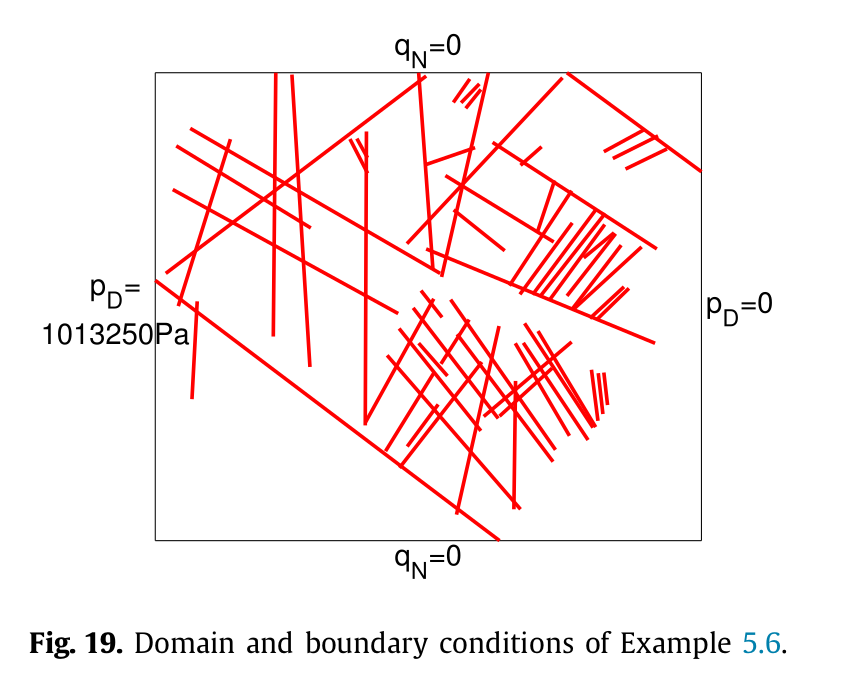
+ 63 fractures represented by line segments
+ Each line segment will be represented by a multilevelset function that is a line and a circle (a line segment is the intersection of a line hyperplane cut by interior of a circle)
+ Permeability: $\mathbf K_m=1e-14$, $\epsilon_ik_{fi} = 1e-10$
+ Domain size: [0,700]x[0,600]

In [ ]:
# Basic NGSolve things
from netgen.geom2d import SplineGeometry
from ngsolve import *

# ngsxfem and the mlset convenience layer 
from xfem import *
from xfem.mlset import *

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
### fracture network
geo = SplineGeometry()
geo.AddRectangle((0, 0), (700, 600), 
                 bcs=("bottom", "right", "top", "left"), 
                leftdomain=1, rightdomain=0)
mesh = Mesh(geo.GenerateMesh(maxh=6))
print(mesh.nv)

# fracture network end points
frac0 = np.loadtxt('network.csv',comments='#',delimiter=',',skiprows=1)

# number of fractures
nfs = int(frac0[-1][0]) 
# each fracture is represented by a mlset with 2 level set functions (line+circle)
level_sets_p1 = tuple(tuple(GridFunction(H1(mesh, order=1)) for i in range(2)) for j in range(nfs))

# interface indicator/interface elements/tangential directions
di = [None for j in range(nfs)]
ts = [None for j in range(nfs)]

ba_fracels = BitArray(mesh.ne) 
ba_fracels[:] = False

# all fractures: 
for i, lset_p1 in enumerate(level_sets_p1):
    x0, y0, x1, y1 = frac0[i][1], frac0[i][2],frac0[i][3],frac0[i][4]
    l1 = (x-x0)/(x1-x0)-(y-y0)/(y1-y0)
    len1 = sqrt((x1-x0)**2+(y1-y0)**2)
    xmid, ymid = 0.5*(x0+x1), 0.5*(y0+y1)
    r1 = sqrt((x-xmid)**2+(y-ymid)**2)-0.5*len1
    InterpolateToP1(l1, lset_p1[0]) # line segment
    InterpolateToP1(r1, lset_p1[1]) # circ
    mlci = MultiLevelsetCutInfo(mesh, lset_p1)
    frac = DomainTypeArray((IF, NEG))
    di[i] = dCut(lset_p1,(IF, NEG),definedonelements=mlci.GetElementsWithContribution(frac))
    ts[i] = Normalize(CF((-grad(lset_p1[0])[1], grad(lset_p1[0])[0])))
    ba_fracels |= lset_elems[i]
# draw the interface elements for the fracture
Draw(BitArrayCF(ba_fracels), mesh, max=1)

In [ ]:
# DFM solver
fes = H1(mesh, order=1, dirichlet="left|right")
K0, epsK1 = 1e-14, 1e-10 # ratio is 10^4

SetHeapSize(int(1e9))
u,v = fes.TnT()
a = BilinearForm(fes, symmetric=True)
a += K0*grad(u)*grad(v)*dx
# fracture contributions
a += sum([epsK1 * grad(u)*ts[i] * grad(v)*ts[i] * di[i] for i in range(nfs)])

f = LinearForm(fes)
gfu = GridFunction(fes)

a.Assemble()

# left dirichlet data
gfu.Set(1013250, definedon=mesh.Boundaries("left"))
f.vec.data -= a.mat*gfu.vec
gfu.vec.data += a.mat.Inverse(fes.FreeDofs())*f.vec
Draw(gfu, mesh, "soln")

In [ ]:
# compare data on cut lines with other methods (a mortar DFM with 25k elems)
# see the above benchmark link for more methods
xx = np.linspace(0, 700, 400)
yy = np.linspace(0, 600, 400)
pre1 = np.array([gfu(mesh(xx0,500)) for xx0 in xx])
pre2 = np.array([gfu(mesh(625,yy0)) for yy0 in yy])

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(yy,pre2)

ref1 = np.loadtxt('mortardfm_real_x625.csv',comments='#',delimiter=',',skiprows=1)
plt.plot(ref1.T[2], ref1.T[0], "k")

plt.subplot(1,2,2)
plt.plot(xx,pre1)
ref2 = np.loadtxt('mortardfm_real_y500.csv',comments='#',delimiter=',',skiprows=1)
plt.plot(ref2.T[3], ref2.T[0], "k")